## AntiNex Django Analysis

Example for showing how to build deep neural networks to defend software applications like the celery workers do automatically.


### Components

1. Using the AntiNex Datasets:
   https://github.com/jay-johnson/antinex-datasets
1. Recording repository
   https://github.com/jay-johnson/network-pipeline
1. Django REST Framework + Celery + JWT + Swagger API:
   https://github.com/jay-johnson/train-ai-with-django-swagger-jwt
1. Utilities
   https://github.com/jay-johnson/antinex-utils

In [1]:
import os
import json
import logging
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Name this Analysis and set up the logger

In [2]:
name = "standalone-scaler-django"
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)-15s %(name)s - %(levelname)s %(message)s")
log = logging.getLogger(name)
log.info("starting")

2018-03-20 06:31:02,215 standalone-scaler-django - INFO starting


## Target Dataset and Model Artifacts

In [3]:
dataset = "/opt/antinex/antinex-datasets/v1/webapps/django/training-ready/v1_django_cleaned.csv"
output_dir = os.getenv(
    "SHARED_DIR",
    "/tmp")
model_backup_file = "{}/{}-full-model.h5".format(output_dir, name)
model_weights_file = "{}/{}-weights.h5".format(output_dir, name)
model_json_file = "{}/{}-model.json".format(output_dir, name)
model_image_file = "{}/{}-predictions-vs-correct.png".format(output_dir, name)
image_title = "{} - Predictions and Correct Predictions".format(output_dir, name)
footnote_text = "AntiNex v1"
show_predictions = False

### Set the Random Seed

In [4]:
seed = 42
np.random.seed(seed)

In [5]:
def build_model(
        num_features,
        loss,
        optimizer,
        metrics):
    """build_model

    Build the Keras Deep Neural Network Model

    :param num_features: number of features
    :param loss: loss function to apply
    :param optimizer: optimizer to use
    :param metrics: list of metrics
    """
    log.info("building model")
    model = Sequential()
    model.add(
        Dense(
            250,
            input_dim=num_features,
            kernel_initializer="uniform",
            activation="relu"))
    model.add(
        Dense(
            1,
            kernel_initializer="uniform",
            activation="sigmoid"))

    log.info(("compiling loss={} optimizer={} metrics={}")
             .format(
                loss,
                optimizer,
                metrics))

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics)

    return model
# end of build_model

### Define Training Features to Process

In [6]:
features_to_process = [
    "idx",
    "arp_hwlen",
    "arp_hwtype",
    "arp_id",
    "arp_op",
    "arp_plen",
    "arp_ptype",
    "dns_default_aa",
    "dns_default_ad",
    "dns_default_an",
    "dns_default_ancount",
    "dns_default_ar",
    "dns_default_arcount",
    "dns_default_cd",
    "dns_default_id",
    "dns_default_length",
    "dns_default_ns",
    "dns_default_nscount",
    "dns_default_opcode",
    "dns_default_qd",
    "dns_default_qdcount",
    "dns_default_qr",
    "dns_default_ra",
    "dns_default_rcode",
    "dns_default_rd",
    "dns_default_tc",
    "dns_default_z",
    "dns_id",
    "eth_id",
    "eth_type",
    "icmp_addr_mask",
    "icmp_code",
    "icmp_gw",
    "icmp_id",
    "icmp_ptr",
    "icmp_seq",
    "icmp_ts_ori",
    "icmp_ts_rx",
    "icmp_ts_tx",
    "icmp_type",
    "icmp_unused",
    "ip_id",
    "ip_ihl",
    "ip_len",
    "ip_tos",
    "ip_version",
    "ipv6_fl",
    "ipv6_hlim",
    "ipv6_nh",
    "ipv6_plen",
    "ipv6_tc",
    "ipv6_version",
    "ipvsix_id",
    "pad_id",
    "tcp_dport",
    "tcp_fields_options.MSS",
    "tcp_fields_options.NOP",
    "tcp_fields_options.SAckOK",
    "tcp_fields_options.Timestamp",
    "tcp_fields_options.WScale",
    "tcp_id",
    "tcp_seq",
    "tcp_sport",
    "udp_dport",
    "udp_id",
    "udp_len",
    "udp_sport"
]

predict_feature = "label_value"
predict_rows_df = None

if not os.path.exists(dataset):
    dataset_url = "https://github.com/jay-johnson/antinex-datasets/raw/master/v1/webapps/django/training-ready/v1_django_cleaned.csv"
    log.info(("downloading url={}")
             .format(
                 dataset_url))
    predict_rows_df = pd.read_csv(dataset_url)
else:
    log.info(("loading dataset={}")
         .format(
            dataset))
    predict_rows_df = pd.read_csv(dataset)
# if available on disk use the file, otherwise download it

2018-03-20 06:31:02,314 standalone-scaler-django - INFO downloading url=https://github.com/jay-johnson/antinex-datasets/raw/master/v1/webapps/django/training-ready/v1_django_cleaned.csv


### Setup Training Parameters

In [7]:
log.info("converting to json")
predict_rows = predict_rows_df.to_json()
found_columns = list(predict_rows_df.columns.values)
num_features = len(found_columns) - 1
min_scaler_range = -1
max_scaler_range = 1
max_records = 100000
verbose = 1
test_size = 0.2
batch_size = 32
epochs = 15
num_splits = 2
loss = "binary_crossentropy"
optimizer = "adam"
metrics = [
    "accuracy"
]
histories = [
    "val_loss",
    "val_acc",
    "loss",
    "acc"
]
label_rules = {
    "labels": [
        "not_attack",
        "not_attack",
        "attack"
    ],
    "label_values": [
        -1,
        0,
        1
    ]
}

should_set_labels = False
labels_dict = {}
if "labels" in label_rules and "label_values" in label_rules:
    label_rows = label_rules["label_values"]
    for idx, lidx in enumerate(label_rows):
        if len(label_rules["labels"]) >= idx:
            should_set_labels = True
            labels_dict[str(lidx)] = label_rules["labels"][idx]
# end of compiling labels dictionary

2018-03-20 06:31:03,610 standalone-scaler-django - INFO converting to json


### Define a Keras Scikit-Learn Handler

In [8]:
# define a function with no arguments for Keras Scikit-Learn API to work
# https://keras.io/scikit-learn-api/
def set_model():
    """set_model"""
    return build_model(
        num_features=num_features,
        loss=loss,
        optimizer=optimizer,
        metrics=metrics)
# end of set_model

### Setup Training and Test Scalers

In [9]:
cast_to_type = "float32"
train_df = predict_rows_df[features_to_process]
test_df = pd.DataFrame(
    {predict_feature: predict_rows_df[predict_feature]})

train_scaler = MinMaxScaler(
    feature_range=(
        min_scaler_range,
        max_scaler_range))
train_only_floats = train_df.values.astype(cast_to_type)
scaled_train_dataset = train_scaler.fit_transform(
    train_only_floats)

test_scaler = MinMaxScaler(
    feature_range=(
        min_scaler_range,
        max_scaler_range))
test_only_floats = test_df.values.astype(cast_to_type)
scaled_test_dataset = test_scaler.fit_transform(
    test_only_floats)

### Build Train and Test records from Scaled Datasets

In [10]:
datanode = {
    "X_train": None,
    "Y_train": None,
    "X_test": None,
    "Y_test": None
}

log.info(("splitting rows={} test_size={}")
         .format(
            len(train_only_floats),
            test_size))

(datanode["X_train"],
 datanode["X_test"],
 datanode["Y_train"],
 datanode["Y_test"]) = train_test_split(
            scaled_train_dataset,
            scaled_test_dataset,
            test_size=test_size,
            random_state=seed)

predict_rows_df[predict_feature] = scaled_test_dataset
train_scaler_df = pd.DataFrame(
    scaled_train_dataset,
    columns=features_to_process)
test_scaler_df = pd.DataFrame(
    scaled_test_dataset,
    columns=[predict_feature])

2018-03-20 06:31:03,978 standalone-scaler-django - INFO splitting rows=30200 test_size=0.2


### Create Train and Test Predictions

In [11]:
sample_rows = train_scaler_df[features_to_process]
target_rows = test_scaler_df
num_samples = len(sample_rows.index)
num_target_rows = len(target_rows.index)

log.info(("scaled datasets ready "
          "x_train={} y_train={} "
          "x_test={} y_test={}")
         .format(
            len(datanode["X_train"]),
            len(datanode["Y_train"]),
            len(datanode["X_test"]),
            len(datanode["Y_test"])))

2018-03-20 06:31:04,011 standalone-scaler-django - INFO scaled datasets ready x_train=24160 y_train=24160 x_test=6040 y_test=6040


### Build Keras Classifier

In [12]:
log.info("building KerasClassifier")

model = KerasClassifier(
    build_fn=set_model,
    epochs=epochs,
    batch_size=batch_size,
    verbose=verbose)

2018-03-20 06:31:04,026 standalone-scaler-django - INFO building KerasClassifier


### Fit Model

In [13]:
log.info(("fitting model epochs={} batch={} "
          "rows={} features={}")
         .format(
            epochs,
            batch_size,
            len(datanode["X_train"]),
            len(found_columns)))

history = model.fit(
    datanode["X_train"],
    datanode["Y_train"],
    validation_data=(
        datanode["X_test"],
        datanode["Y_test"]),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
    verbose=verbose)

2018-03-20 06:31:04,047 standalone-scaler-django - INFO fitting model epochs=15 batch=32 rows=24160 features=68
2018-03-20 06:31:04,049 standalone-scaler-django - INFO building model
2018-03-20 06:31:04,082 standalone-scaler-django - INFO compiling loss=binary_crossentropy optimizer=adam metrics=['accuracy']


Train on 24160 samples, validate on 6040 samples
Epoch 1/15
24160/24160 [==============================] - 2s 65us/step - loss: 0.5867 - acc: 0.7017 - val_loss: -0.3003 - val_acc: 0.0000e+00
Epoch 2/15
24160/24160 [==============================] - 1s 59us/step - loss: 0.5585 - acc: 0.7009 - val_loss: -0.5013 - val_acc: 0.0000e+00
Epoch 3/15
24160/24160 [==============================] - 1s 52us/step - loss: 0.5001 - acc: 0.7020 - val_loss: -0.7091 - val_acc: 0.1601
Epoch 4/15
24160/24160 [==============================] - 1s 57us/step - loss: 0.3700 - acc: 0.8576 - val_loss: -1.4144 - val_acc: 0.2947
Epoch 5/15
24160/24160 [==============================] - 1s 58us/step - loss: 0.2391 - acc: 0.9529 - val_loss: -2.2905 - val_acc: 0.2947
Epoch 6/15
24160/24160 [==============================] - 1s 57us/step - loss: 0.1568 - acc: 0.9596 - val_loss: -2.8234 - val_acc: 0.2947
Epoch 7/15
24160/24160 [==============================] - 1s 58us/step - loss: 0.0906 - acc: 0.9940 - val_loss: -3.

### Build Pipeline and Cross Validate using Stratified K-Folds

In [14]:
log.info("building estimators")

estimators = []
estimators.append(
    ("standardize",
        StandardScaler()))
estimators.append(
    ("mlp",
        model))

log.info("building pipeline")
pipeline = Pipeline(estimators)

# noqa https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
log.info(("starting classification "
          "StratifiedKFold "
          "splits={} seed={}")
         .format(
            num_splits,
            seed))

kfold = StratifiedKFold(
    n_splits=num_splits,
    random_state=seed)

log.info(("classification cross_val_score"))
results = cross_val_score(
    pipeline,
    datanode["X_train"],
    datanode["Y_train"],
    cv=kfold)
scores = [
    results.std(),
    results.mean()
]
accuracy = {
    "accuracy": results.mean() * 100
}

log.info(("classification accuracy={} samples={}")
         .format(
            accuracy["accuracy"],
            num_samples))

2018-03-20 06:31:24,604 standalone-scaler-django - INFO building estimators
2018-03-20 06:31:24,606 standalone-scaler-django - INFO building pipeline
2018-03-20 06:31:24,609 standalone-scaler-django - INFO starting classification StratifiedKFold splits=2 seed=42
2018-03-20 06:31:24,610 standalone-scaler-django - INFO classification cross_val_score
2018-03-20 06:31:24,628 standalone-scaler-django - INFO building model
2018-03-20 06:31:24,658 standalone-scaler-django - INFO compiling loss=binary_crossentropy optimizer=adam metrics=['accuracy']


Epoch 1/15
12080/12080 [==============================] - 1s 62us/step - loss: 0.5750 - acc: 0.7003
Epoch 2/15
12080/12080 [==============================] - 1s 50us/step - loss: 0.5002 - acc: 0.7323
Epoch 3/15
12080/12080 [==============================] - 1s 50us/step - loss: 0.3661 - acc: 0.8589
Epoch 4/15
12080/12080 [==============================] - 1s 47us/step - loss: 0.2261 - acc: 0.9615
Epoch 5/15
12080/12080 [==============================] - 1s 50us/step - loss: 0.1334 - acc: 0.9947
Epoch 6/15
12080/12080 [==============================] - 1s 49us/step - loss: 0.0800 - acc: 0.9973
Epoch 7/15
12080/12080 [==============================] - 1s 47us/step - loss: 0.0515 - acc: 0.9976
Epoch 8/15
12080/12080 [==============================] - 1s 49us/step - loss: 0.0358 - acc: 0.9977
Epoch 9/15
12080/12080 [==============================] - 1s 47us/step - loss: 0.0265 - acc: 0.9980
Epoch 10/15
12080/12080 [==============================] - 1s 47us/step - loss: 0.0205 - acc: 0.9982

2018-03-20 06:31:34,307 standalone-scaler-django - INFO building model
2018-03-20 06:31:34,331 standalone-scaler-django - INFO compiling loss=binary_crossentropy optimizer=adam metrics=['accuracy']


Epoch 1/15
12080/12080 [==============================] - 1s 61us/step - loss: 0.5691 - acc: 0.7028
Epoch 2/15
12080/12080 [==============================] - 1s 52us/step - loss: 0.4952 - acc: 0.7370
Epoch 3/15
12080/12080 [==============================] - 1s 48us/step - loss: 0.3566 - acc: 0.8714
Epoch 4/15
12080/12080 [==============================] - 1s 50us/step - loss: 0.2059 - acc: 0.9727
Epoch 5/15
12080/12080 [==============================] - 1s 49us/step - loss: 0.1091 - acc: 0.9967
Epoch 6/15
12080/12080 [==============================] - 1s 51us/step - loss: 0.0619 - acc: 0.9978
Epoch 7/15
12080/12080 [==============================] - 1s 56us/step - loss: 0.0390 - acc: 0.9982
Epoch 8/15
12080/12080 [==============================] - 1s 52us/step - loss: 0.0275 - acc: 0.9979
Epoch 9/15
12080/12080 [==============================] - 1s 49us/step - loss: 0.0206 - acc: 0.9982
Epoch 10/15
12080/12080 [==============================] - 1s 49us/step - loss: 0.0165 - acc: 0.9983

2018-03-20 06:31:44,199 standalone-scaler-django - INFO classification accuracy=99.82201986754967 samples=30200


### Make Predictions

In [15]:
predictions = model.predict(
    sample_rows.values,
    verbose=verbose)

30200/30200 [==============================] - 1s 21us/step


### Create Confusion Matrix

In [16]:
log.info(("classification confusion_matrix samples={} "
          "predictions={} target_rows={}")
         .format(
            num_samples,
            len(predictions),
            num_target_rows))

cm = confusion_matrix(
    target_rows.values,
    predictions)

log.info(("classification has confusion_matrix={} "
          "predictions={} target_rows={}")
         .format(
            cm,
            len(predictions),
            num_target_rows))
# end of confusion matrix

2018-03-20 06:31:44,852 standalone-scaler-django - INFO classification confusion_matrix samples=30200 predictions=30200 target_rows=30200
2018-03-20 06:31:44,880 standalone-scaler-django - INFO classification has confusion_matrix=[[21195     5]
 [   49  8951]] predictions=30200 target_rows=30200


### Round Predictions

In [17]:
rounded = [round(x[0]) for x in predictions]
sample_predictions = []

log.info(("scores={} accuracy={} "
          "merging samples={} with predictions={} "
          "labels={}")
         .format(
            scores,
            accuracy.get("accuracy", None),
            len(sample_rows.index),
            len(rounded),
            labels_dict))

2018-03-20 06:31:44,952 standalone-scaler-django - INFO scores=[0.00012417218543048225, 0.9982201986754967] accuracy=99.82201986754967 merging samples=30200 with predictions=30200 labels={'-1': 'not_attack', '0': 'not_attack', '1': 'attack'}


### Merge Correct Answers with Predicted Answers

In [18]:
ridx = 0
for idx, row in predict_rows_df.iterrows():
    if len(sample_predictions) > max_records:
        log.info(("hit max={} predictions")
                 .format(
                    max_records))
        break
    new_row = json.loads(row.to_json())
    cur_value = rounded[ridx]
    if predict_feature in row:
        new_row["_original_{}".format(
                predict_feature)] = \
            int(row[predict_feature])
    else:
        new_row["_original_{}".format(
                predict_feature)] = \
            "missing-from-dataset"
    if cur_value != int(row[predict_feature]):
        new_row["prediction_status"] = 1
    else:
        new_row["prediction_status"] = 0

    new_row[predict_feature] = int(cur_value)

    if should_set_labels:
        new_row["label_name"] = \
            labels_dict[str(int(cur_value))]
    new_row["_row_idx"] = ridx
    new_row["_count"] = idx
    sample_predictions.append(new_row)
    ridx += 1
# end of merging samples with predictions

### (Optional) Print Out Every Prediction and Original

In [19]:
log.info(("creating merged_predictions_df from sample_predictions={}")
         .format(
            len(sample_predictions)))

merged_predictions_df = pd.DataFrame(
    sample_predictions)

if show_predictions:
    for row_num, row in merged_predictions_df.iterrows():
        log.info(("row={} original_{}={} predicted={}")
                 .format(
                    row_num,
                    predict_feature,
                    row["_original_{}".format(
                        predict_feature)],
                    row[predict_feature]))
    # end seeing original vs predicted
# if showing all predictions to log

2018-03-20 06:31:50,081 standalone-scaler-django - INFO creating merged_predictions_df from sample_predictions=30200


### Save Weights + Model as JSON + full Model to files

In [20]:
log.debug("saving weights")

# there are some known issues saving weights:
# https://github.com/keras-team/keras/issues/4875
model.model.save_weights(model_weights_file)

log.debug("saving full keras model to file")

model.model.save(model_backup_file)

log.debug("saving keras model as json to file")

with open(
        model_json_file,
        "w") as json_file:
    json_file.write(model.model.to_json())

log.info(("neural network created "
          "merged_predictions_df.index={} columns={} "
          "with cross_val_score={} and accuracy={}")
         .format(
            len(merged_predictions_df.index),
            merged_predictions_df.columns.values,
            scores,
            accuracy.get("accuracy", None)))

log.info(("saved model_backup_file={} "
          "model_weights_file={} model_json_file={}")
         .format(
            model_backup_file,
            model_weights_file,
            model_json_file))

2018-03-20 06:31:50,803 standalone-scaler-django - DEBUG saving weights
2018-03-20 06:31:50,827 standalone-scaler-django - DEBUG saving full keras model to file
2018-03-20 06:31:50,887 standalone-scaler-django - DEBUG saving keras model as json to file
2018-03-20 06:31:50,890 standalone-scaler-django - INFO neural network created merged_predictions_df.index=30200 columns=['_count' '_original_label_value' '_row_idx' 'arp_hwlen' 'arp_hwtype'
 'arp_id' 'arp_op' 'arp_plen' 'arp_ptype' 'dns_default_aa'
 'dns_default_ad' 'dns_default_an' 'dns_default_ancount' 'dns_default_ar'
 'dns_default_arcount' 'dns_default_cd' 'dns_default_id'
 'dns_default_length' 'dns_default_ns' 'dns_default_nscount'
 'dns_default_opcode' 'dns_default_qd' 'dns_default_qdcount'
 'dns_default_qr' 'dns_default_ra' 'dns_default_rcode' 'dns_default_rd'
 'dns_default_tc' 'dns_default_z' 'dns_id' 'eth_id' 'eth_type'
 'icmp_addr_mask' 'icmp_code' 'icmp_gw' 'icmp_id' 'icmp_ptr' 'icmp_seq'
 'icmp_ts_ori' 'icmp_ts_rx' 'icmp_ts_

## Show Prediction Distributions
### 0.0 values are correct predictions
### 1.0 values are not-correct predictions

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
2018-03-20 06:31:51,091 matplotlib.font_manager - DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-03-20 06:31:51,128 matplotlib.font_manager - DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0 to DejaVu Sans ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


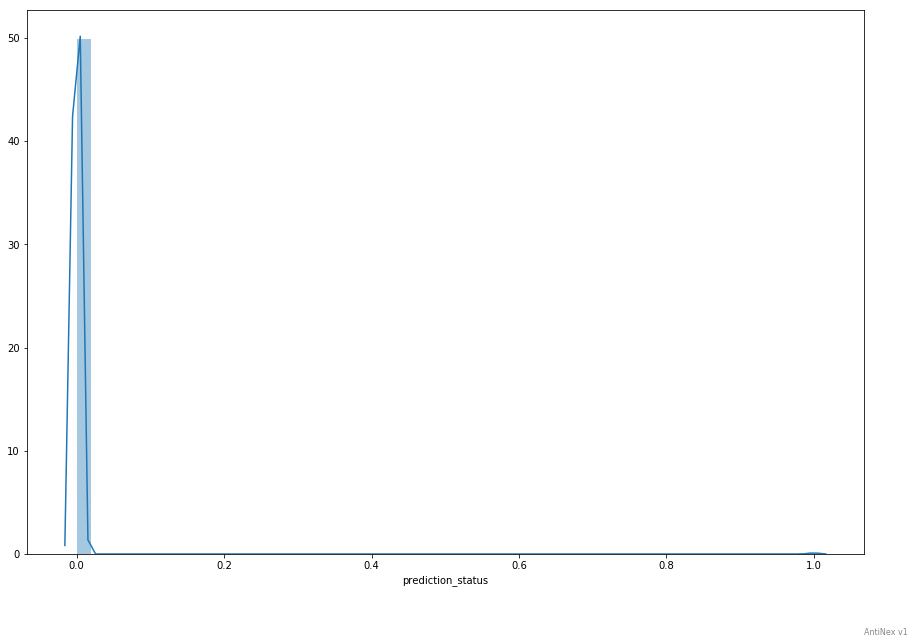

In [21]:
fig, ax = plt.subplots(figsize=(15.0, 10.0))
ax = sns.distplot(merged_predictions_df["prediction_status"])
ax.get_figure().text(
    0.90,
    0.01,
    footnote_text,
    va="bottom",
    fontsize=8,
    color="#888888")
plt.show()

### Display Location of Analysis and Model Files

In [22]:
log.info(("saved model_backup_file={} model_weights_file={} "
          "model_json_file={}")
         .format(
            model_backup_file,
            model_weights_file,
            model_json_file))

2018-03-20 06:31:51,386 standalone-scaler-django - INFO saved model_backup_file=/data/standalone-scaler-django-full-model.h5 model_weights_file=/data/standalone-scaler-django-weights.h5 model_json_file=/data/standalone-scaler-django-model.json
